In [ ]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Import the evaluation module
from pyspark.ml.evaluation import *
# Import the model tuning module
from pyspark.ml.tuning import *
import numpy as np
from pyspark.sql.functions import col, when, avg, count, desc
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.cloud import storage

In [ ]:
# Reload the saved Parquet file
final_assembled_sdf = spark.read.parquet("gs://my-project-bucket-steam/trusted/steam_reviews_features_leo5_final_assembled_df.parquet")

from pyspark.sql.functions import col, when
final_assembled_sdf = final_assembled_sdf.withColumn("voted_up", when(col("voted_up") > 0, 1.0).otherwise(0.0))

final_assembled_sdf.printSchema()

root
 |-- game: string (nullable = true)
 |-- game_index: double (nullable = true)
 |-- game_onehot: vector (nullable = true)
 |-- author_num_games_owned: double (nullable = true)
 |-- author_num_reviews: double (nullable = true)
 |-- author_playtime_forever: double (nullable = true)
 |-- author_playtime_last_two_weeks: double (nullable = true)
 |-- author_playtime_at_review: double (nullable = true)
 |-- days_since_last_play: double (nullable = true)
 |-- sentiment_score: double (nullable = true)
 |-- votes_up: double (nullable = true)
 |-- voted_up: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
# Split the dataset into training and testing sets:

train_data, test_data = final_assembled_sdf.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="voted_up")

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Apply the model to the test set
predictions = lr_model.transform(test_data)

In [ ]:
# Show model coefficients and intercept
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)

Coefficients:  [0.537554273130892,2.1475141089334406,1.3496595202967454,0.40863288246906015,-0.02418859164766699,0.4601879508284451,1.9695377599636712,0.9434202933840267,-0.8273875995936267,1.1077137856694073,0.1710063206984129,1.9171110809208418,-0.0463328247325773,2.542601960458059,-0.10849035557664546,0.4861020389130178,0.11990397892948514,0.010971889299367833,0.508998498261762,2.1223732888683555,1.4954561798673558,0.8189762795164847,1.6953179600343762,-1.1015057867183045,0.9199242197193428,0.045357914569077826,2.1581139621569454,2.0778061514452877,-0.36945665974600317,1.5379867691377826,1.9380851819566716,1.15908063217407,-0.4963571488037748,-0.11499350398921149,0.13057430589051355,2.6948167555586964,0.6857193616364412,0.9671036974771823,1.9468853668477106,1.5752373062474345,-0.7693963401888256,1.7305143007891879,0.9456581738569421,0.06445235231758988,1.6885367982825108,-0.7473834762890962,0.5581819935510469,1.9734409904603694,2.0266000707730565,2.867176681206014,0.7409709468444342

In [ ]:
# Test the model on the testData
test_results = lr_model.transform(test_data)

# Show the test results
test_results.select(
    'game',
    'author_num_games_owned',
    'author_num_reviews',
    'author_playtime_forever',
    'author_playtime_last_two_weeks',
    'author_playtime_at_review',
    'days_since_last_play',
    'sentiment_score',
    'votes_up',
    'rawPrediction',
    'probability',
    'prediction',
    'voted_up'
).show(truncate=False)

+-------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+--------------------+--------------------+--------+----------------------------------------+-----------------------------------------+----------+--------+
|game         |author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|days_since_last_play|sentiment_score     |votes_up|rawPrediction                           |probability                              |prediction|voted_up|
+-------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+--------------------+--------------------+--------+----------------------------------------+-----------------------------------------+----------+--------+
|7 Days to Die|0.0                   |1.0               |57.0                   |0.0                           |57.0     

In [ ]:
# Show the confusion matrix
test_results.groupby('voted_up').pivot('prediction').count().sort('voted_up').show()

+--------+------+-------+
|voted_up|   0.0|    1.0|
+--------+------+-------+
|     0.0|213325| 798939|
|     1.0|123871|7279438|
+--------+------+-------+



In [ ]:
# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(labelCol="voted_up", metricName="areaUnderROC")

# Create the parameter grid (empty for now)
grid = ParamGridBuilder().build()

# Create the CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3 )

# Use the CrossValidator to Fit the training data
cv = cv.fit(train_data)

# Show the average performance over the three folds
cv.avgMetrics

[0.839541902576587]

In [ ]:
# Test the predictions
predictions = cv.transform(test_data)

# Calculate AUC
auc = evaluator.evaluate(predictions)
print("AUC:", auc)

# Create the confusion matrix
predictions.groupby('voted_up').pivot('prediction').count().fillna(0).show()
cm = predictions.groupby('voted_up').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1] # True Negative
    fp = cm[0][2] # False Positive
    fn = cm[1][1] # False Negative
    tp = cm[1][2] # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print( calculate_recall_precision(cm) )

AUC: {auc}


+--------+------+-------+
|voted_up|   0.0|    1.0|
+--------+------+-------+
|     1.0|123948|7279361|
|     0.0|213389| 798875|
+--------+------+-------+



(0.10965658547552258, 0.09889225816131146, 0.7891962966182735, 0.17576040921841485)


In [ ]:
# Create a grid to hold hyperparameters
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid
grid = grid.build()
print('Number of models to be tested: ', len(grid))

# Create the CrossValidator using the new hyperparameter grid
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

# Call cv.fit() to create models with all of the combinations of parameters in the grid
all_models = cv.fit(train_data)
print("Average Metrics for Each model: ", all_models.avgMetrics)

Number of models to be tested:  12


Average Metrics for Each model:  [0.83954199492096, 0.8395422441919839, 0.8308122377880887, 0.5, 0.8288712706540613, 0.5, 0.828099149870008, 0.5, 0.8277081546137462, 0.5, 0.8274785699458421, 0.5]


In [ ]:
# Gather the metrics and parameters of the model with the best average metrics
hyperparams = all_models.getEstimatorParamMaps()[np.argmax(all_models.avgMetrics)]

# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])

# Choose the best model
bestModel = all_models.bestModel
print("Area under ROC curve:", bestModel.summary.areaUnderROC)

(Param(parent='LogisticRegression_91d5f0c64055', name='regParam', doc='regularization parameter (>= 0).'), 0.0)
(Param(parent='LogisticRegression_91d5f0c64055', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 0.0)


Area under ROC curve: 0.8395811980155914


In [ ]:
# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(test_data)

# Show the test results
test_results.select(
    'game',
    'author_num_games_owned',
    'author_num_reviews',
    'author_playtime_forever',
    'author_playtime_last_two_weeks',
    'author_playtime_at_review',
    'days_since_last_play',
    'sentiment_score',
    'votes_up',
    'rawPrediction',
    'probability',
    'prediction',
    'voted_up'
).show(truncate=False)

# Evaluate the predictions. Area Under ROC curve
print(evaluator.evaluate(test_results))

+-------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+--------------------+--------------------+--------+----------------------------------------+-----------------------------------------+----------+--------+
|game         |author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|days_since_last_play|sentiment_score     |votes_up|rawPrediction                           |probability                              |prediction|voted_up|
+-------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+--------------------+--------------------+--------+----------------------------------------+-----------------------------------------+----------+--------+
|7 Days to Die|0.0                   |1.0               |57.0                   |0.0                           |57.0     

0.8395846873169575


In [ ]:
# Save the best model
model_path = "gs://my-bigdata-project-bl/models/steam_reviews_logistic_regression_model"
bestModel.write().overwrite().save(model_path)

In [ ]:
# Load up the model from disk. Note the use of LogisticRegressionModel
model_path = "gs://my-bigdata-project-bl/models/steam_reviews_logistic_regression_model"
myModel = LogisticRegressionModel.load(model_path)

# **Visualization**

In [ ]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in predictions.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
        print("Found variable:", variable)
        idx = variable['idx']
        name = variable['name']
        var_index[idx] = name # Add the name to the dictionary

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(i, var_index[i], coeff[i])


Found variable: {'idx': 299, 'name': 'author_num_games_owned'}
Found variable: {'idx': 300, 'name': 'author_num_reviews'}
Found variable: {'idx': 301, 'name': 'author_playtime_forever'}
Found variable: {'idx': 302, 'name': 'author_playtime_last_two_weeks'}
Found variable: {'idx': 303, 'name': 'author_playtime_at_review'}
Found variable: {'idx': 304, 'name': 'days_since_last_play'}
Found variable: {'idx': 305, 'name': 'sentiment_score'}
Found variable: {'idx': 0, 'name': 'game_onehot_Counter-Strike 2'}
Found variable: {'idx': 1, 'name': 'game_onehot_Terraria'}
Found variable: {'idx': 2, 'name': 'game_onehot_Team Fortress 2'}
Found variable: {'idx': 3, 'name': "game_onehot_Tom Clancy's Rainbow Six Siege"}
Found variable: {'idx': 4, 'name': 'game_onehot_Grand Theft Auto V'}
Found variable: {'idx': 5, 'name': 'game_onehot_Rust'}
Found variable: {'idx': 6, 'name': "game_onehot_Garry's Mod"}
Found variable: {'idx': 7, 'name': 'game_onehot_Among Us'}
Found variable: {'idx': 8, 'name': 'game_o

LogisticRegression_91d5f0c64055__aggregationDepth 2
LogisticRegression_91d5f0c64055__elasticNetParam 1.0
LogisticRegression_91d5f0c64055__family auto
LogisticRegression_91d5f0c64055__featuresCol features
LogisticRegression_91d5f0c64055__fitIntercept True
LogisticRegression_91d5f0c64055__labelCol voted_up
LogisticRegression_91d5f0c64055__maxBlockSizeInMB 0.0
LogisticRegression_91d5f0c64055__maxIter 100
LogisticRegression_91d5f0c64055__predictionCol prediction
LogisticRegression_91d5f0c64055__probabilityCol probability
LogisticRegression_91d5f0c64055__rawPredictionCol rawPrediction
LogisticRegression_91d5f0c64055__regParam 0.0
LogisticRegression_91d5f0c64055__standardization True
LogisticRegression_91d5f0c64055__threshold 0.5
LogisticRegression_91d5f0c64055__tol 1e-06


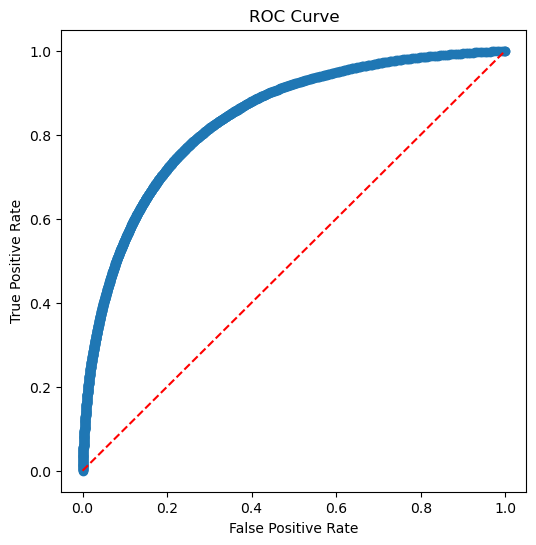

In [ ]:
# Look at the parameters for the best model that was evaluated from the grid
parammap = all_models.bestModel.extractParamMap()

for p, v in parammap.items():
    print(p, v)

mymodel = all_models.bestModel

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'r--')
x = mymodel.summary.roc.select('FPR').collect()
y = mymodel.summary.roc.select('TPR').collect()
plt.scatter(x, y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("reviews_roc.png")

# Create a memory buffer named img_data to hold the figure
img_data = io.BytesIO()

# Write the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()

# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-bl')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("roccurve.png")

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

plt.show()

In [ ]:
# Group by 'game' and calculate average sentiment score and total votes
df_grouped = final_assembled_sdf.groupBy("game").agg(
    avg("sentiment_score").alias("avg_sentiment_score"),
    count("votes_up").alias("total_votes_up"),
    avg("days_since_last_play").alias("avg_days_since_last_play"),
    avg("author_num_reviews").alias("avg_num_reviews"),
    avg("author_playtime_forever").alias("avg_playtime_forever")
)

# Filter to get games with significant votes
df_significant = df_grouped.filter(col("total_votes_up") > 10000)

# Random sample for visualization
df_sampled = df_significant.sample(False, 0.25)

# Convert to Pandas DataFrame
pandas_df = df_sampled.toPandas()
pandas_df

,game,avg_sentiment_score,total_votes_up,avg_days_since_last_play,avg_num_reviews,avg_playtime_forever
0,Planet Zoo,0.171624,36840,969.024919,10.896824,10593.750407
1,Just Cause 3,0.108083,50722,1063.211328,23.135089,4357.435393
2,Resident Evil 7 Biohazard,0.083107,27982,1131.206954,32.303481,1654.747516
3,Metro Exodus,0.158111,30451,1166.934649,27.598503,2401.596926
4,Pizza Tower,0.112663,31338,438.688142,12.455868,3858.588232
...,...,...,...,...,...,...
75,Cookie Clicker,0.086609,31277,532.052403,21.281069,44418.729354
76,Trove,0.093655,41458,1150.952048,16.209055,13843.027884
77,Scrap Mechanic,0.157335,45471,893.620703,10.630710,13666.065690
78,Half-Life: Alyx,0.185855,58724,942.810895,19.728816,2067.992320


/tmp/ipykernel_10012/2222013465.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


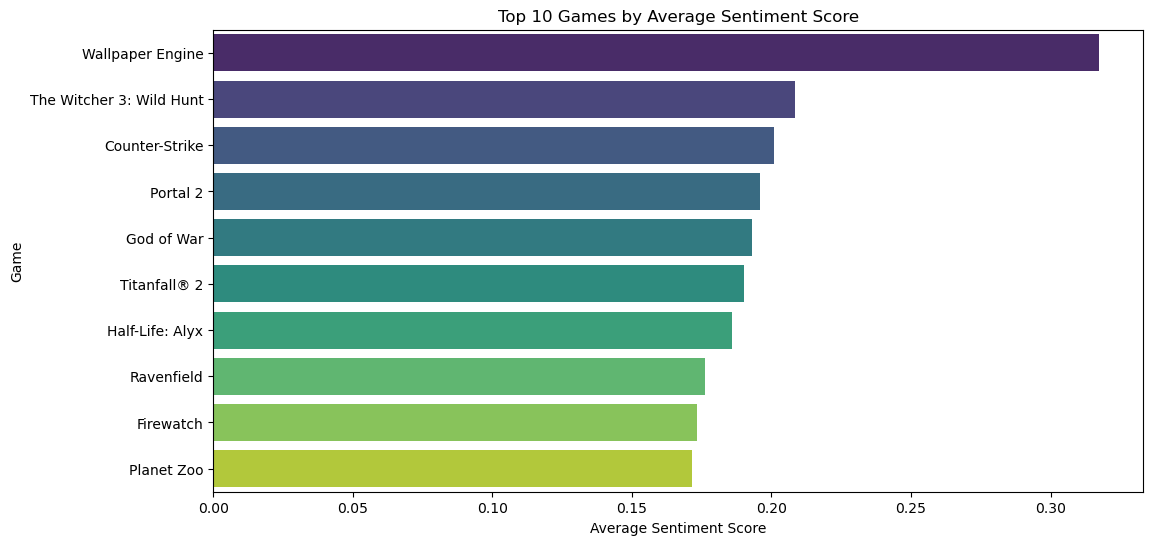

In [ ]:
# Bar plot showing the top 10 games by avg sentiment score
plt.figure(figsize=(12, 6))
sns.barplot(
    data=pandas_df.sort_values("avg_sentiment_score", ascending=False).head(10),
    x="avg_sentiment_score", y="game", palette="viridis"
)
plt.title("Top 10 Games by Average Sentiment Score")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Game")
# plt.tight_layout()

# Create a memory buffer named img_data to hold the figure
img_data = io.BytesIO()

# Write the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()

# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-bl')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("top_10_games_avg_sentiment_score.png")

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

plt.show()

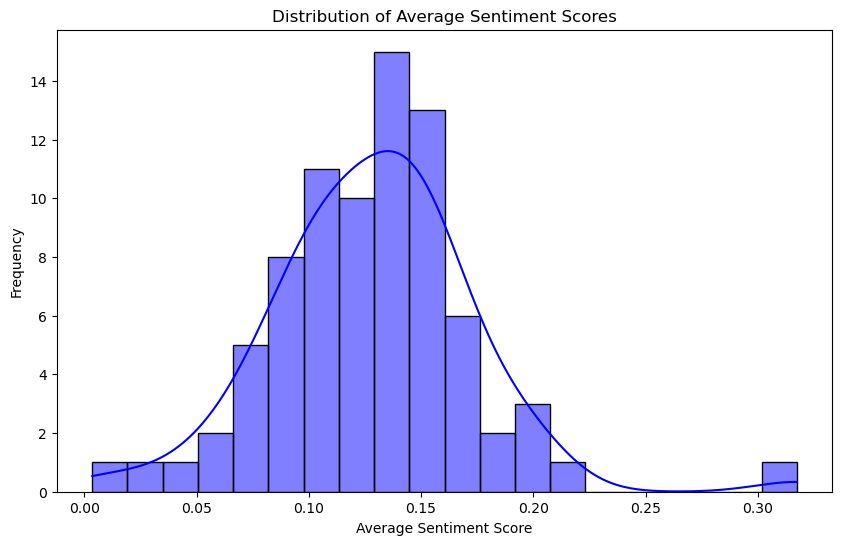

In [ ]:
# Histogram of the distribution of avg sentiment score
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df["avg_sentiment_score"], bins=20, kde=True, color="blue")
plt.title("Distribution of Average Sentiment Scores")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Frequency")
# plt.tight_layout()

# Create a memory buffer named img_data to hold the figure
img_data = io.BytesIO()

# Write the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()

# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-bl')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("distribution_avg_sentiment_scores.png")

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

plt.show()

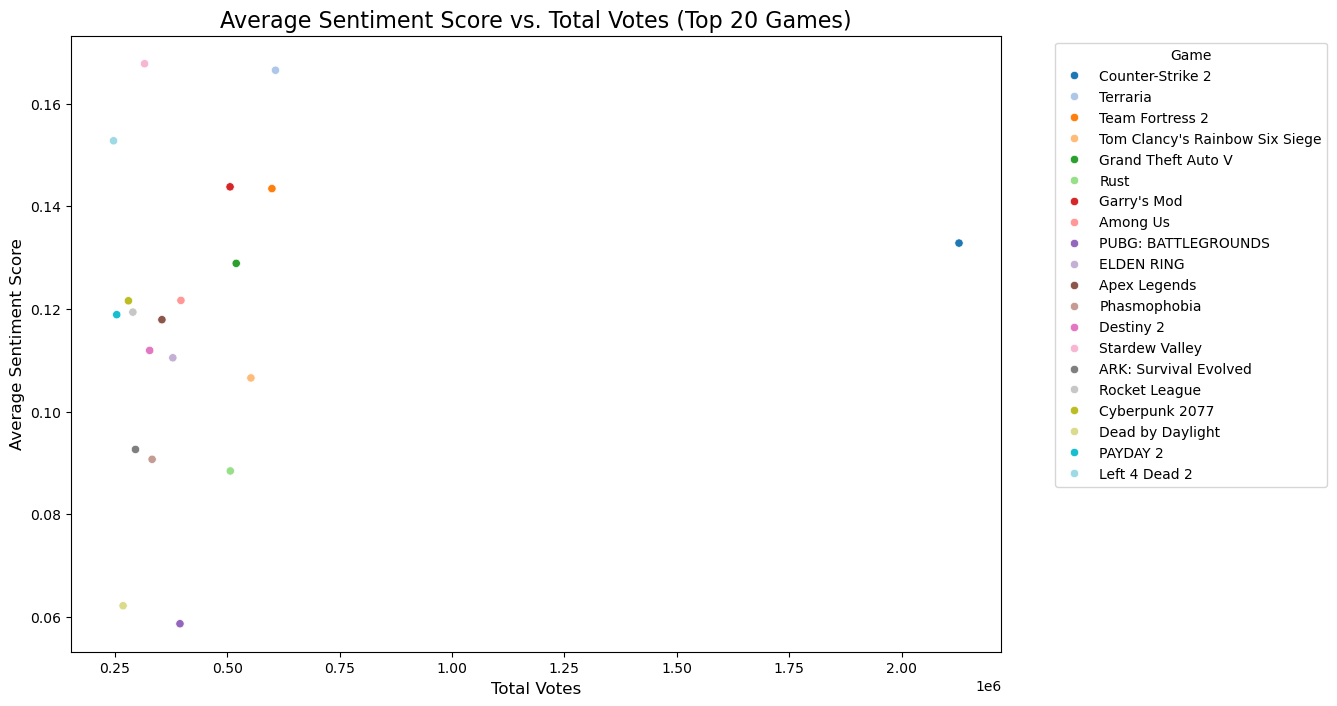

In [ ]:
# Filter top 30 games by total_votes_up
top_games_sdf = df_grouped.orderBy(col("total_votes_up").desc()).limit(20)

# Convert to Pandas for visualization
pandas_df_top_games = top_games_sdf.toPandas()

# Scatterplot of sentiment score vs. total votes for top 10 games
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pandas_df_top_games,
    x="total_votes_up",
    y="avg_sentiment_score",
    hue="game",
    palette="tab20"
)
plt.title("Average Sentiment Score vs. Total Votes (Top 20 Games)", fontsize=16)
plt.xlabel("Total Votes", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.legend(title="Game", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
# plt.tight_layout()

# Create a memory buffer named img_data to hold the figure
img_data = io.BytesIO()

# Write the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()

# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-bl')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("scatter_sentiment_vs_votes_top20.png")

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

plt.show()

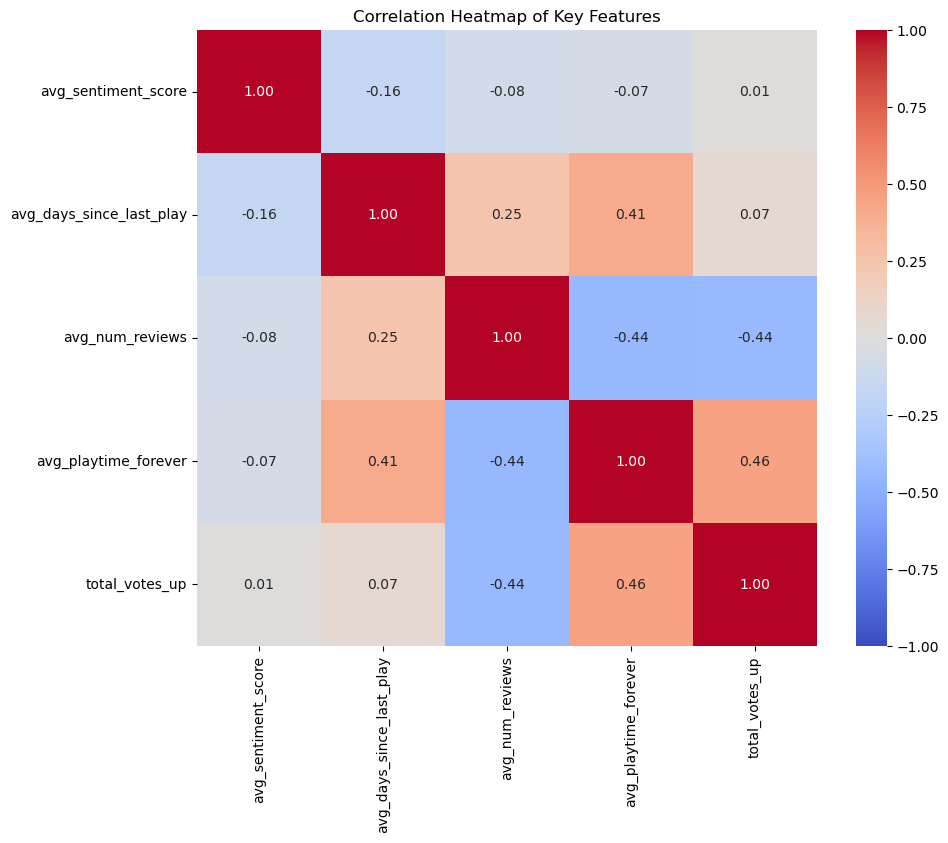

In [ ]:
# Compute Correlation Matrix
# Select relevant features for correlation heatmap
correlation_df = pandas_df[[
    "avg_sentiment_score",
    "avg_days_since_last_play",
    "avg_num_reviews",
    "avg_playtime_forever",
    "total_votes_up"
]].dropna()

# Compute the correlation matrix
correlation_matrix = correlation_df.corr()

# Heatmap for Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Heatmap of Key Features")

# Create a memory buffer named img_data to hold the figure
img_data = io.BytesIO()

# Write the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()

# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-bl')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("correlation_heatmap.png")

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

plt.show()

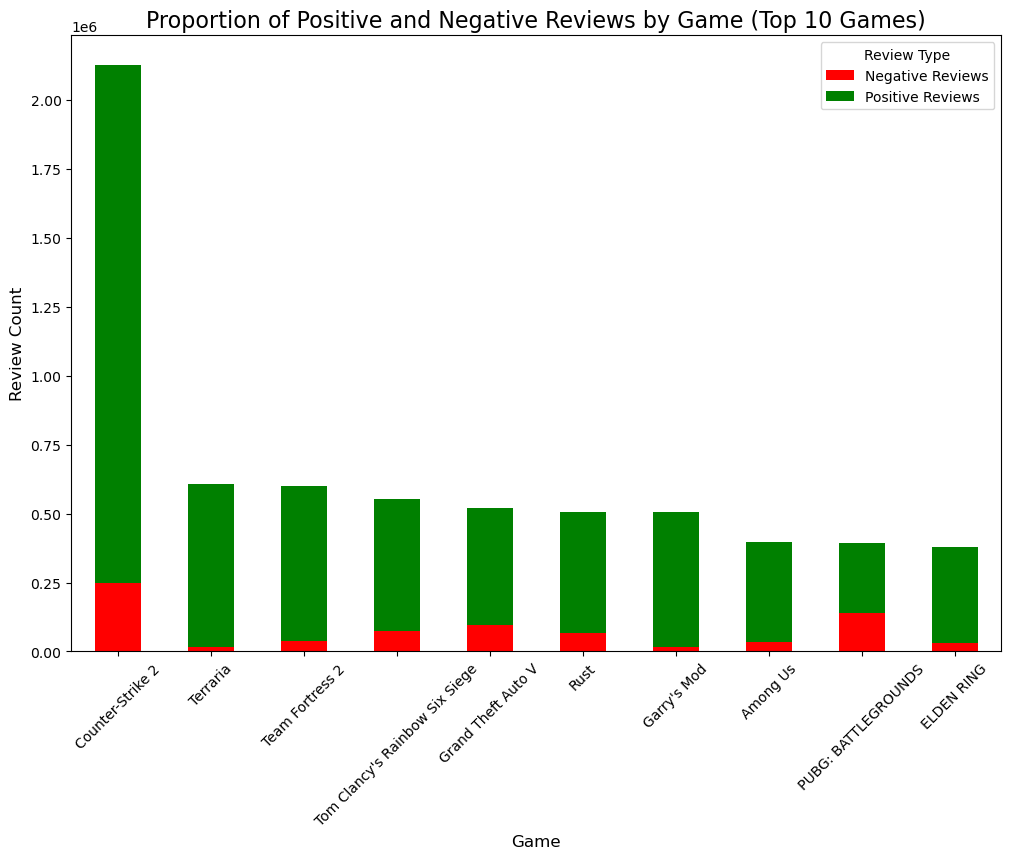

In [ ]:
# Group data by game and voted_up
voted_up_grouped = final_assembled_sdf.groupBy("game", "voted_up").count().toPandas()

# Pivot data for visualization
voted_up_pivot = voted_up_grouped.pivot(index="game", columns="voted_up", values="count").fillna(0)
voted_up_pivot.columns = ["Negative Reviews", "Positive Reviews"]

# Add a total reviews column and sort by it
voted_up_pivot["Total Reviews"] = voted_up_pivot["Negative Reviews"] + voted_up_pivot["Positive Reviews"]
voted_up_pivot = voted_up_pivot.sort_values(by="Total Reviews", ascending=False)

# Select top 10 games
top_10_games = voted_up_pivot.head(10)

# Drop the Total Reviews column (optional, since it's not needed for visualization)
top_10_games = top_10_games.drop(columns=["Total Reviews"])

# Stacked bar plot for top 10 games
top_10_games.plot(kind="bar", stacked=True, figsize=(12, 8), color=["red", "green"])
plt.title("Proportion of Positive and Negative Reviews by Game (Top 10 Games)", fontsize=16)
plt.xlabel("Game", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Review Type")
# plt.tight_layout()

# Create a memory buffer named img_data to hold the figure
img_data = io.BytesIO()

# Write the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()

# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-bl')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("stacked_bar_reviews_top10.png")

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

plt.show()
